# Importing required Modules and Packages

In [ ]:
# some useful modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si
# from pyomo.environ import *

# install pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt'
except:
    pass

from pyomo.opt import SolverStatus, TerminationCondition

# Download Stock Market Data


In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['AMC','NFE','HL','NAVI', 'BTC-USD','ETH-USD','USDT-USD','BNB-USD']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2020',interval='1d') for ticker in tickers_list}

In [ ]:
# take a peak!
dow_prices

{'AMC':                  open       high        low      close   adjclose    volume  \
 2017-01-03  34.049999  34.750000  33.900002  34.750000  27.085867    766100   
 2017-01-04  34.000000  34.799999  34.000000  34.200001  26.657169    547900   
 2017-01-05  34.250000  34.450001  33.500000  34.000000  26.501284    443200   
 2017-01-06  34.049999  34.349998  33.700001  33.799999  26.345392    336700   
 2017-01-09  33.650002  34.049999  33.250000  33.299999  25.955662    415100   
 ...               ...        ...        ...        ...        ...       ...   
 2020-12-23   2.580000   2.650000   2.540000   2.560000   2.560000  15724800   
 2020-12-24   2.590000   2.600000   2.480000   2.510000   2.510000  11094200   
 2020-12-28   2.630000   2.630000   2.360000   2.390000   2.390000  23942700   
 2020-12-29   2.440000   2.460000   2.280000   2.290000   2.290000  21086100   
 2020-12-30   2.300000   2.300000   2.130000   2.160000   2.160000  40278400   
 
            ticker  
 2017-01-0

# Data Cleaning

In [ ]:
prep_data = pd.DataFrame(dow_prices['AMC']['adjclose']).rename(columns = {"adjclose":"AMC"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,AMC,NFE,HL,NAVI,BTC-USD,ETH-USD,USDT-USD,BNB-USD
2017-01-03,27.085867,NaN,5.372740,12.822714,1043.839966,NaN,NaN,NaN
2017-01-04,26.657169,NaN,5.441122,12.984733,1154.729980,NaN,NaN,NaN
2017-01-05,26.501284,NaN,5.695105,12.745561,1013.380005,NaN,NaN,NaN
2017-01-06,26.345392,NaN,5.538807,12.969302,902.200989,NaN,NaN,NaN
2017-01-09,25.955662,NaN,5.529039,12.730131,902.828003,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-23,2.560000,53.575211,6.000041,9.286823,23241.345703,583.714600,0.999426,31.097898
2020-12-24,2.510000,56.146114,6.198719,9.334596,23735.949219,611.607178,0.999931,32.500591
2020-12-28,2.390000,53.801765,6.218586,9.258161,27084.808594,730.397339,0.998603,35.844559
2020-12-29,2.290000,52.107533,6.109313,9.334596,27362.437500,731.520142,0.998590,38.952831


In [ ]:
prep_data.shape

(1006, 8)

Rather than use the raw time series, let's build a model based on past returns (the difference from the previous day).

In [ ]:
# we will just use a pct_change as the return
final_df = pd.DataFrame()
for i in tickers_list:
  final_df[i] = prep_data[i].pct_change()

# drop the na records
final_df.dropna(inplace=True)
final_df

,AMC,NFE,HL,NAVI,BTC-USD,ETH-USD,USDT-USD,BNB-USD
2019-02-01,-0.031399,0.067330,-0.022222,0.003509,0.008720,0.005126,-0.000180,0.046931
2019-02-04,0.011276,0.002867,-0.011364,-0.003496,-0.008255,0.001968,-0.006442,0.081962
2019-02-05,-0.019512,-0.000715,0.034483,0.003509,0.002082,-0.003507,-0.000294,0.101304
2019-02-06,-0.019900,0.001431,-0.029630,-0.001748,-0.015171,-0.023494,0.001472,0.034063
2019-02-07,-0.034083,0.004286,-0.019084,-0.004378,-0.004188,-0.003660,0.000075,-0.044007
...,...,...,...,...,...,...,...,...
2020-12-23,-0.011583,0.015876,0.023729,0.045161,-0.022776,-0.080553,-0.000215,-0.071232
2020-12-24,-0.019531,0.047987,0.033113,0.005144,0.021281,0.047785,0.000505,0.045106
2020-12-28,-0.047809,-0.041754,0.003205,-0.008188,0.141088,0.194226,-0.001328,0.102889
2020-12-29,-0.041841,-0.031490,-0.017572,0.008256,0.010250,0.001537,-0.000013,0.086715


In [ ]:
final_df.shape

(483, 8)

# Visualize the Time Series

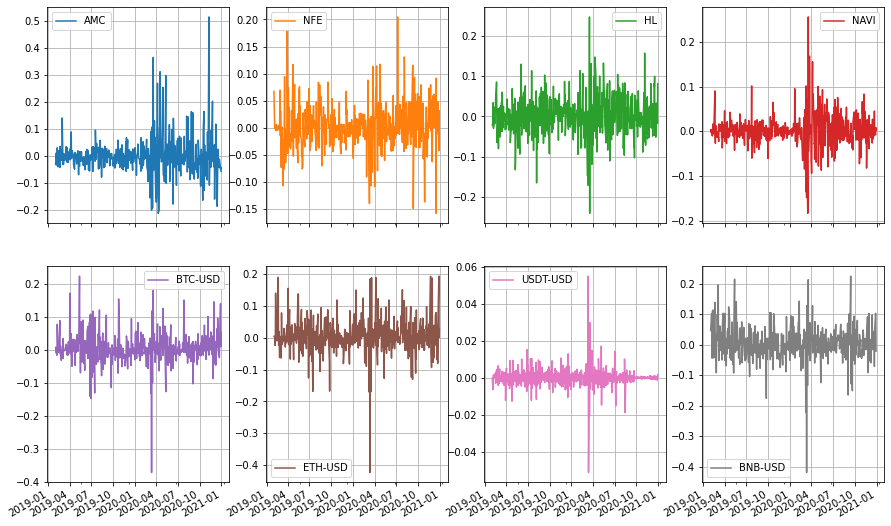

In [ ]:
final_df.plot(subplots=True,
        grid=True, 
        layout=(3,4),
         figsize=(15,15))
plt.show()

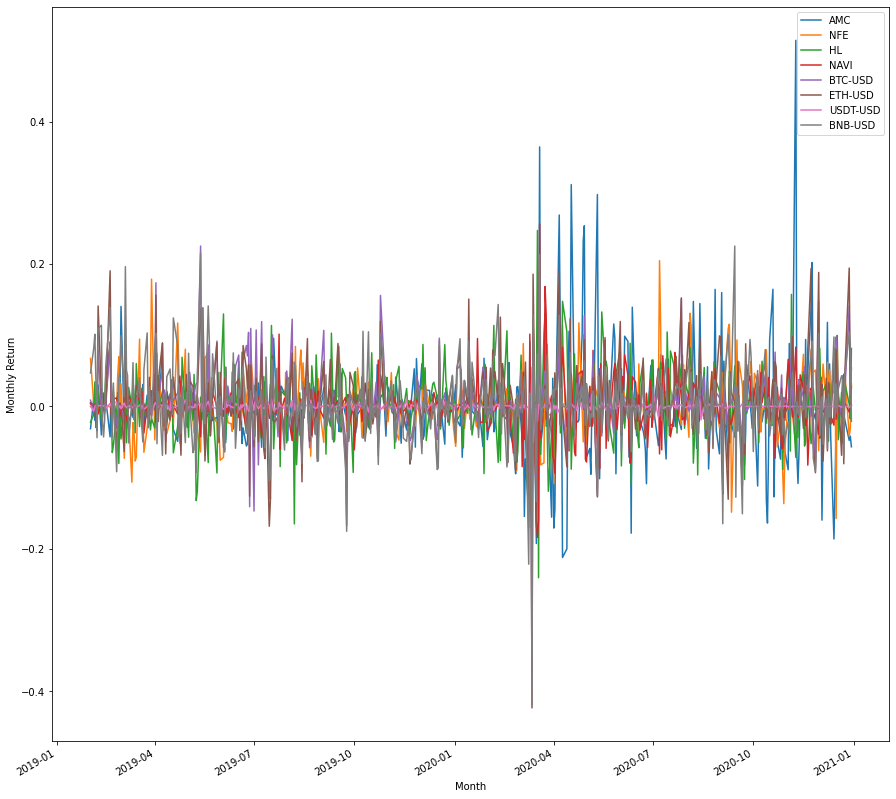

In [ ]:
final_df.plot(figsize=(15,15))
plt.xlabel('Month')
plt.ylabel('Monthly Return')
plt.show()

# Average Returns, Covariance and Correlations

In [ ]:
Averages = pd.DataFrame(np.mean(final_df) ,columns=["Avg_Return"])
Averages['Std_Dev_Return'] = pd.DataFrame(np.std(final_df))
Averages
# Std_Dev_Return = pd.DataFrame(np.std(final_df) ,columns=["Std_Dev_Return"])
# print(Std_Dev_Return)

,Avg_Return,Std_Dev_Return
AMC,-0.001691,0.066617
NFE,0.003827,0.041387
HL,0.003107,0.049210
NAVI,0.000637,0.037673
BTC-USD,0.005455,0.045215
ETH-USD,0.005619,0.055099
USDT-USD,0.000002,0.005427
BNB-USD,0.005328,0.055109


In [ ]:
# here's the covariance matrix
Covariance_matrix = final_df.cov()
Covariance_matrix

,AMC,NFE,HL,NAVI,BTC-USD,ETH-USD,USDT-USD,BNB-USD
AMC,0.004447,0.000280,0.000148,0.001053,0.000323,0.000605,-0.000016,0.000488
NFE,0.000280,0.001716,0.000309,0.000376,0.000177,0.000237,-0.000009,0.000341
HL,0.000148,0.000309,0.002427,0.000410,0.000555,0.000632,-0.000023,0.000526
NAVI,0.001053,0.000376,0.000410,0.001422,0.000373,0.000540,-0.000003,0.000480
BTC-USD,0.000323,0.000177,0.000555,0.000373,0.002049,0.002063,-0.000021,0.001678
ETH-USD,0.000605,0.000237,0.000632,0.000540,0.002063,0.003042,-0.000040,0.002180
USDT-USD,-0.000016,-0.000009,-0.000023,-0.000003,-0.000021,-0.000040,0.000030,-0.000047
BNB-USD,0.000488,0.000341,0.000526,0.000480,0.001678,0.002180,-0.000047,0.003043


In [ ]:
Corr_matrix = final_df.corr()
Corr_matrix

,AMC,NFE,HL,NAVI,BTC-USD,ETH-USD,USDT-USD,BNB-USD
AMC,1.000000,0.101346,0.045202,0.418702,0.106958,0.164457,-0.044274,0.132755
NFE,0.101346,1.000000,0.151601,0.240387,0.094224,0.103819,-0.040088,0.149120
HL,0.045202,0.151601,1.000000,0.220952,0.249030,0.232643,-0.085572,0.193619
NAVI,0.418702,0.240387,0.220952,1.000000,0.218270,0.259570,-0.012618,0.230494
BTC-USD,0.106958,0.094224,0.249030,0.218270,1.000000,0.826453,-0.085182,0.672100
ETH-USD,0.164457,0.103819,0.232643,0.259570,0.826453,1.000000,-0.132750,0.716365
USDT-USD,-0.044274,-0.040088,-0.085572,-0.012618,-0.085182,-0.132750,1.000000,-0.156529
BNB-USD,0.132755,0.149120,0.193619,0.230494,0.672100,0.716365,-0.156529,1.000000


In [ ]:
# creating covariance table on stock return dataframe
df_cov = final_df.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = final_df.mean()
print('Average Return:')
print(df_return)

df_return[0]

Covariance Matrix:
               AMC       NFE        HL      NAVI   BTC-USD   ETH-USD  \
AMC       0.004447  0.000280  0.000148  0.001053  0.000323  0.000605   
NFE       0.000280  0.001716  0.000309  0.000376  0.000177  0.000237   
HL        0.000148  0.000309  0.002427  0.000410  0.000555  0.000632   
NAVI      0.001053  0.000376  0.000410  0.001422  0.000373  0.000540   
BTC-USD   0.000323  0.000177  0.000555  0.000373  0.002049  0.002063   
ETH-USD   0.000605  0.000237  0.000632  0.000540  0.002063  0.003042   
USDT-USD -0.000016 -0.000009 -0.000023 -0.000003 -0.000021 -0.000040   
BNB-USD   0.000488  0.000341  0.000526  0.000480  0.001678  0.002180   

          USDT-USD   BNB-USD  
AMC      -0.000016  0.000488  
NFE      -0.000009  0.000341  
HL       -0.000023  0.000526  
NAVI     -0.000003  0.000480  
BTC-USD  -0.000021  0.001678  
ETH-USD  -0.000040  0.002180  
USDT-USD  0.000030 -0.000047  
BNB-USD  -0.000047  0.003043  


Average Return:
AMC        -0.001691
NFE         0.

-0.0016912938662152998

# Part 2: Model Building

In [ ]:
model = ConcreteModel()

# defining variables
# each one is a stock

model.AMC = Var(within=NonNegativeReals, bounds=(0,1))
model.NFE = Var(within=NonNegativeReals, bounds=(0,1))
model.HL = Var(within=NonNegativeReals, bounds=(0,1))
model.NAVI = Var(within=NonNegativeReals, bounds=(0,1))
model.BTC = Var(within=NonNegativeReals, bounds=(0,1))
model.ETH = Var(within=NonNegativeReals, bounds=(0,1))
model.USDT = Var(within=NonNegativeReals, bounds=(0,1))
model.BNB = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# declare objective
model.objective = Objective(expr =               
                        model.AMC*df_return[0] + 
                        model.NFE*df_return[1] + 
                        model.HL*df_return[2] +
                        model.NAVI*df_return[3]+ 
                        model.BTC*df_return[4]+
                        model.ETH*df_return[5]+
                        model.USDT*df_return[6]+
                        model.BNB*df_return[7],
                        sense=maximize) # yes, we want to MAX our returns!

In [ ]:
# declare constraints
# 1. Sum of all proportions = 1
model.sum_proportions = Constraint(expr = model.AMC + model.NFE+ model.HL+ model.NAVI + model.BTC+ model.ETH + model.USDT + model.BNB == 1)

# 2. Minimum return should be 0.005 or 0.5%
model.return_floor = Constraint(expr = model.objective >= 0.005)


In [ ]:
df_cov.columns

Index(['AMC', 'NFE', 'HL', 'NAVI', 'BTC-USD', 'ETH-USD', 'USDT-USD',
       'BNB-USD'],
      dtype='object')

In [ ]:
for index, col in enumerate(df_cov.columns):
  print(index,col)

0 AMC
1 NFE
2 HL
3 NAVI
4 BTC-USD
5 ETH-USD
6 USDT-USD
7 BNB-USD


In [ ]:
# creating calculations table for calculate the risk
# 3. Max risk should be less than 0.0055
max_risk = 0.0055
def calc_risk():
  proportions = [ model.AMC , model.NFE, model.HL, model.NAVI , model.BTC, model.ETH , model.USDT , model.BNB]
  risk_matrix = [] 
  
  for index, col in enumerate(df_cov.columns):
    i = 0
    risk = []
    for row in df_cov[col]:
      risk.append(proportions[index]*row*proportions[i])
      i = i + 1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() 

risk_limits = np.arange(0.0001, 0.0055, 0.00005) # take tiny steps

In [ ]:
param_analysis = {} 
returns = {} 
for r in risk_limits:
  model.total_risk = Constraint(expr = calc_risk() <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(model)
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue
  result = result.write()
  param_analysis[r] = [model.AMC() , model.NFE(), model.HL(), model.NAVI() , model.BTC(), model.ETH() , model.USDT() , model.BNB()]
  returns[r] =  model.AMC()*df_return[0] + model.NFE()*df_return[1]+ model.HL()*df_return[2] +model.NAVI()*df_return[3]+ model.BTC()*df_return[4]+ model.ETH()*df_return[5]+ model.USDT()*df_return[6]+ model.BNB()*df_return[7]

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="

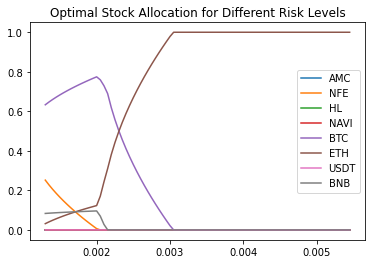

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'AMC', 'NFE', 'HL', 'NAVI', 'BTC','ETH','USDT','BNB']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.0013000000000000002, 0.0013500000000000003, 0.0014000000000000002, 0.0014500000000000003, 0.0015000000000000002, 0.0015500000000000004, 0.0016000000000000003, 0.0016500000000000004, 0.0017000000000000003, 0.0017500000000000003, 0.0018000000000000004, 0.0018500000000000003, 0.0019000000000000004, 0.0019500000000000003, 0.0020000000000000005, 0.00205, 0.0021000000000000003, 0.00215, 0.0022, 0.0022500000000000003, 0.0023000000000000004, 0.00235, 0.0024000000000000002, 0.0024500000000000004, 0.0025, 0.00255, 0.0026000000000000003, 0.0026500000000000004, 0.0027, 0.0027500000000000003, 0.0028000000000000004, 0.0028500000000000005, 0.0029000000000000002, 0.0029500000000000004, 0.0030000000000000005, 0.00305, 0.0031000000000000003, 0.0031500000000000005, 0.0032000000000000006, 0.0032500000000000003, 0.0033000000000000004, 0.0033500000000000005, 0.0034000000000000002, 0.0034500000000000004, 0.0035000000000000005, 0.0035500000000000006, 0.0036000000000000003, 0.0036500000000000005, 0.00370000

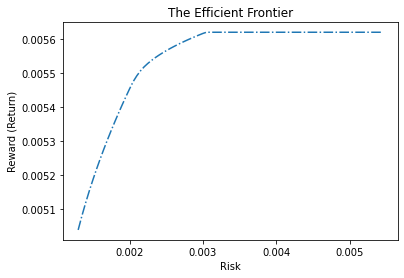

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

We keep the risk level at 0.2% as the returns are not very high after that for the increasing risk

In [ ]:
# The optimum allocations at 0.2% risk are:
param_analysis.loc[0.0020:0.002005,:]

,AMC,NFE,HL,NAVI,BTC,ETH,USDT,BNB
0.002,4.327370e-07,0.006426,0.000002,7.370496e-07,0.774414,0.123154,6.871030e-07,0.096002


# Part 3: Simulation
For this part, we identify 4 stocks for our portfolio, thus adding a constraint to include 4 stocks out of the 8 total.

In [ ]:
#model
model1 = ConcreteModel()

# Variables

model1.AMC = Var(within=NonNegativeReals, bounds=(0,1))
model1.NFE = Var(within=NonNegativeReals, bounds=(0,1))
model1.HL = Var(within=NonNegativeReals, bounds=(0,1))
model1.NAVI = Var(within=NonNegativeReals, bounds=(0,1))
model1.BTC = Var(within=NonNegativeReals, bounds=(0,1))
model1.ETH = Var(within=NonNegativeReals, bounds=(0,1))
model1.USDT = Var(within=NonNegativeReals, bounds=(0,1))
model1.BNB = Var(within=NonNegativeReals, bounds=(0,1))


# declare objective
model1.objective = Objective(expr =               
                        model1.AMC*df_return[0] + 
                        model1.NFE*df_return[1] + 
                        model1.HL*df_return[2] +
                        model1.NAVI*df_return[3]+ 
                        model1.BTC*df_return[4]+
                        model1.ETH*df_return[5]+
                        model1.USDT*df_return[6]+
                        model1.BNB*df_return[7],
                        sense=maximize)

#constraints

# declare constraints
# 1. Sum of all proportions = 1
model1.sum_proportions = Constraint(expr = model1.AMC + model1.NFE+ model1.HL+ model1.NAVI + model1.BTC+ model1.ETH + model1.USDT + model1.BNB == 1)

# 2. Minimum return should be 0.005 or 0.5%
model1.return_floor = Constraint(expr = model1.objective >= 0.005)

# 3. Select atleast 4 stocks
model1.bin_var = Var(range(8), within = Binary)
stocks = [ model1.AMC , model1.NFE, model1.HL, model1.NAVI , model1.BTC, model1.ETH , model1.USDT , model1.BNB]

model1.stocks_constraints = ConstraintList()

bin_var_expr = 0

for i in range(8):
  model1.stocks_constraints.add(0.01*model1.bin_var[i] <= stocks[i])
  model1.stocks_constraints.add(1*model1.bin_var[i] >= stocks[i])
  bin_var_expr += model1.bin_var[i]
model1.stocks_constraints.add(bin_var_expr == 4)

# 3. Max risk should be less than 0.0055
max_risk = 0.0055
def calc_risk():
  proportions = [ model1.AMC , model1.NFE, model1.HL, model1.NAVI , model1.BTC, model1.ETH , model1.USDT , model1.BNB]
  risk_matrix = [] 
  
  for index, col in enumerate(df_cov.columns):
    i = 0
    risk = []
    for row in df_cov[col]:
      risk.append(proportions[index]*row*proportions[i])
      i = i + 1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() 

risk_limits = np.arange(0.0001, 0.0055, 0.00005)

#Solver
param_analysis = {} 
returns = {} 
for r in risk_limits:
  model1.total_risk = Constraint(expr = calc_risk() <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(model1)
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue
  result = result.write()
  param_analysis[r] = [model1.AMC() , model1.NFE(), model1.HL(), model1.NAVI() , model1.BTC(), model1.ETH() , model1.USDT() , model1.BNB()]
  returns[r] =  model1.AMC()*df_return[0] + model1.NFE()*df_return[1]+ model1.HL()*df_return[2] +model1.NAVI()*df_return[3]+ model1.BTC()*df_return[4]+ model1.ETH()*df_return[5]+ model1.USDT()*df_return[6]+ model1.BNB()*df_return[7]

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="

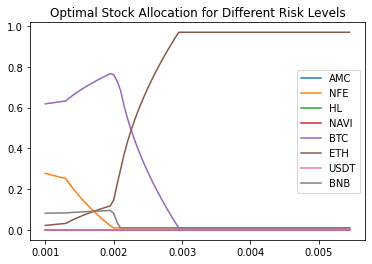

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'AMC', 'NFE', 'HL', 'NAVI', 'BTC','ETH','USDT','BNB']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.0010000000000000002, 0.0013000000000000002, 0.0013500000000000003, 0.0014000000000000002, 0.0014500000000000003, 0.0015000000000000002, 0.0015500000000000004, 0.0016000000000000003, 0.0016500000000000004, 0.0017000000000000003, 0.0017500000000000003, 0.0018000000000000004, 0.0018500000000000003, 0.0019000000000000004, 0.0019500000000000003, 0.0020000000000000005, 0.00205, 0.0021000000000000003, 0.00215, 0.0022, 0.0022500000000000003, 0.0023000000000000004, 0.00235, 0.0024000000000000002, 0.0024500000000000004, 0.0025, 0.00255, 0.0026000000000000003, 0.0026500000000000004, 0.0027, 0.0027500000000000003, 0.0028000000000000004, 0.0028500000000000005, 0.0029000000000000002, 0.0029500000000000004, 0.0030000000000000005, 0.00305, 0.0031000000000000003, 0.0031500000000000005, 0.0032000000000000006, 0.0032500000000000003, 0.0033000000000000004, 0.0033500000000000005, 0.0034000000000000002, 0.0034500000000000004, 0.0035000000000000005, 0.0035500000000000006, 0.0036000000000000003, 0.00365000

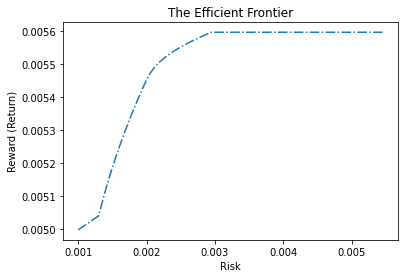

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

In [ ]:
param_analysis.loc[0.0020:0.002005,:]

,AMC,NFE,HL,NAVI,BTC,ETH,USDT,BNB
0.002,0.000002,0.010026,0.000015,0.000003,0.76214,0.146295,0.000003,0.081515


The four stocks in our allocation will be NFE, BTC, ETH, BNB

Now, we run simulations on the four stock returns and calculate the portfolio returns and calculate the probability of our portfolio losing money.

In [ ]:
data = final_df[['BTC-USD','NFE','BNB-USD','ETH-USD']]
mean_data = data.mean()
cov_data = data.cov()

In [ ]:
# Simulating the returns for the 4 stocks
random_draws = np.random.multivariate_normal(mean_data, cov_data, 10000)
random_draws.shape

(10000, 4)

In [ ]:
# Selecting 4 assets for our allocations
assets = ['BTC','NFE','BNB','ETH']
n_assets = len(assets)
assets = param_analysis.loc[:,assets]
alloc = assets.loc[0.0020:0.002005,:] #our optimal risk level is 0.2%
print(alloc)
alloc = np.array(assets.loc[0.0020:0.002005,:])

           BTC       NFE       BNB       ETH
0.002  0.76214  0.010026  0.081515  0.146295


In [ ]:
random_draws = np.random.multivariate_normal(mean_data, cov_data, 10000)
random_draws.shape

(10000, 4)

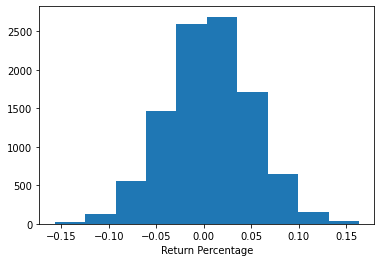

In [ ]:
# Using our allocation of optimal 
portfolio = 0
for i in range(n_assets):
  portfolio += random_draws[:,i]*alloc[0,i]

# Creating a hist to see the distribution
plt.hist(portfolio)
plt.xlabel('Return Percentage')
plt.show()

In [ ]:
# Statistics
print(portfolio.mean())
print(portfolio.std())

0.005649482135533072
0.044806529081409974


In [ ]:
# Converting it to a dataFrame 
portfolio = pd.DataFrame(portfolio)
portfolio.columns = ['Return']


In [ ]:
# Checking when we will lose the money
portfolio['is_negative'] = np.where(portfolio['Return']<0,1,0)
portfolio

,Return,is_negative
0,0.046460,0
1,-0.013856,1
2,-0.011451,1
3,-0.051007,1
4,-0.043218,1
...,...,...
9995,-0.033130,1
9996,0.020819,0
9997,-0.015756,1
9998,0.031611,0


In [ ]:
print('Probability of losing money:',portfolio['is_negative'].mean())

Probability of losing money: 0.4501


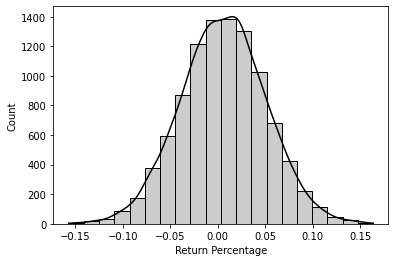

In [ ]:
import seaborn as sns
sns.histplot(portfolio['Return'],kde=True,bins=20,color = 'black',alpha=0.2)
plt.xlabel('Return Percentage')
plt.show()

**Inference:** The plot suggests that return percentage is normally distributed with a mean approximately $0.005$. This means we have chance of losing money. This probability as per our analysis is $0.45$.

# Part 4: Analysis

## 4.1 
We are allocating a budget of $100,000 to use for our portfolio. 

The stocks and allocations that we will be using are: 

* NFE (0.010026)
* ETH (0.146295)
* BTC (0.76214)
* BNB (0.081515)

In [ ]:
param_analysis.loc[0.0020:0.002005,:]

,AMC,NFE,HL,NAVI,BTC,ETH,USDT,BNB
0.002,0.000003,0.1,0.099996,0.000007,0.088579,0.711359,0.000001,0.000056


In [ ]:
# Assign the ticker list that we want to scrape
tickers_list = ['NFE', 'BTC-USD','ETH-USD','BNB-USD','SNP','DJI']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2021',end_date='12/2/2021'rval='1mo') for ticker in tickers_list}

In [ ]:
prep_data = pd.DataFrame(dow_prices['NFE']['adjclose']).rename(columns = {"adjclose":"NFE"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,NFE,BTC-USD,ETH-USD,BNB-USD,SNP,DJI
2021-01-01,44.010674,33114.359375,1314.986206,44.275993,43.466259,29982.599609
2021-02-01,46.552017,45137.769531,1416.048950,209.574402,50.432594,30932.400391
2021-03-01,45.222252,58918.832031,1918.362061,302.063446,48.333527,32981.601562
2021-04-01,41.970268,57750.175781,2773.207031,624.080566,45.088684,33874.898438
2021-05-01,41.555698,37332.855469,2714.945312,354.329346,49.497639,34529.398438
2021-06-01,37.476574,35040.835938,2274.547607,303.295868,46.756935,34502.500000
2021-07-01,29.987192,41626.195312,2536.209961,333.549591,43.473949,34935.500000
2021-08-01,29.057205,47166.687500,3433.732666,464.418732,45.632431,35064.300781
2021-09-01,27.454458,43790.894531,3001.678955,387.057343,46.754459,33843.898438
2021-10-01,29.778385,61318.957031,4288.074219,524.364441,48.680000,35819.601562


In [ ]:
NFE_shares = (100000*.010026)/44.010670
BTC_USD_shares = (100000*0.146295)/33114.359375
ETH_USD_shares = (100000*0.76214)/1314.986206	
BNB_USD_shares = (100000*0.081515)/44.275993
SNP_shares = 100000/43.466259
DJI_shares = 100000/29982.599609

portfolio_return = pd.DataFrame()
portfolio_return['NFE Price Allocation'] = NFE_shares * prep_data.NFE 
portfolio_return['BTC Price Allocation'] = BTC_USD_shares * prep_data['BTC-USD']
portfolio_return['ETH Price Allocation'] = ETH_USD_shares * prep_data['ETH-USD']
portfolio_return['BNB Price Allocation'] = BNB_USD_shares * prep_data['BNB-USD']
portfolio_return['Aggregate Total'] = portfolio_return['NFE Price Allocation'] + portfolio_return['BTC Price Allocation'] + portfolio_return['ETH Price Allocation'] + portfolio_return['BNB Price Allocation']
portfolio_return['SNP Price Allocation'] = SNP_shares * prep_data.SNP
portfolio_return['DJI Price Allocation'] = DJI_shares * prep_data.DJI

portfolio_return

,NFE Price Allocation,BTC Price Allocation,ETH Price Allocation,BNB Price Allocation,Aggregate Total,SNP Price Allocation,DJI Price Allocation
2021-01-01,1002.600080,14629.500000,76214.000003,8151.500064,99997.600147,100000.000006,100000.000001
2021-02-01,1060.494022,19941.288668,82071.396793,38584.018584,141657.198067,116026.995328,103167.839994
2021-03-01,1030.200852,26029.585638,111184.471301,55611.856756,193856.114547,111197.806582,110002.474744
2021-04-01,956.117936,25513.288269,160729.595273,114897.315506,302096.316984,103732.608049,112981.859076
2021-05-01,946.673686,16493.177564,157352.861272,65234.350848,240027.063370,113876.003689,115164.791872
2021-06-01,853.747808,15480.592680,131828.281210,55838.753686,204001.375385,107570.644899,115075.078379
2021-07-01,683.133405,18389.920138,146993.713760,61408.662061,227475.429364,100017.692878,116519.249350
2021-08-01,661.947522,20837.638650,199012.354817,85502.527100,306014.468089,104983.571350,116948.834452
2021-09-01,625.435601,19346.256538,173971.376155,71259.789196,265202.857489,107564.949128,112878.465773
2021-10-01,678.376606,27089.930134,248528.301678,96538.924381,372835.532800,111994.916115,119467.964852


**Did this portfolio do better than investing in the S&P 500 or Dow Jones Index?**

As we can see from the aggregate total of our optimal portfolio; ours outperformed the S&P 500 and the Dow Jows Index. 

This is largely due to our large allocation in ETH which increases our aggregate total by $137224.115 by itself without accounting for anything else in our portfolio. 

## 4.2 Optimizing the Portfolio

In [ ]:
#model
model2 = ConcreteModel()

# Variables

model2.AMC = Var(within=NonNegativeReals, bounds=(0,1))
model2.NFE = Var(within=NonNegativeReals, bounds=(0,1))
model2.HL = Var(within=NonNegativeReals, bounds=(0,1))
model2.NAVI = Var(within=NonNegativeReals, bounds=(0,1))
model2.BTC = Var(within=NonNegativeReals, bounds=(0,1))
model2.ETH = Var(within=NonNegativeReals, bounds=(0,1))
model2.USDT = Var(within=NonNegativeReals, bounds=(0,1))
model2.BNB = Var(within=NonNegativeReals, bounds=(0,1))


# declare objective
model2.objective = Objective(expr =               
                        model2.AMC*df_return[0] + 
                        model2.NFE*df_return[1] + 
                        model2.HL*df_return[2] +
                        model2.NAVI*df_return[3]+ 
                        model2.BTC*df_return[4]+
                        model2.ETH*df_return[5]+
                        model2.USDT*df_return[6]+
                        model2.BNB*df_return[7],
                        sense=maximize)

#constraints

# declare constraints
# 1. Sum of all proportions = 1
model2.sum_proportions = Constraint(expr = model2.AMC + model2.NFE+ model2.HL+ model2.NAVI + model2.BTC+ model2.ETH + model2.USDT + model2.BNB == 1)

# 2. Minimum return should be 0.005 or 0.5%
model2.return_floor = Constraint(expr = model2.objective >= 0.005)

# 3. Select at least 10% of the budget to 2 stocks
model2.bin_var = Var(range(4), within = Binary)
stocks = [ model2.AMC , model2.NFE, model2.HL, model2.NAVI]

model2.stocks_constraints = ConstraintList()

bin_var_expr = 0

for i in range(4):
  model2.stocks_constraints.add(0.1*model2.bin_var[i] <= stocks[i])
  model2.stocks_constraints.add(1*model2.bin_var[i] >= stocks[i])
  bin_var_expr += model2.bin_var[i]
model2.stocks_constraints.add(bin_var_expr >= 2)

# 4. Max risk should be less than 0.0055
max_risk = 0.0055
def calc_risk():
  proportions = [ model2.AMC , model2.NFE, model2.HL, model2.NAVI , model2.BTC, model2.ETH , model2.USDT , model2.BNB]
  risk_matrix = [] 
  
  for index, col in enumerate(df_cov.columns):
    i = 0
    risk = []
    for row in df_cov[col]:
      risk.append(proportions[index]*row*proportions[i])
      i = i + 1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() 

risk_limits = np.arange(0.0001, 0.0055, 0.00005)

# 5. One Stock Constraint
model2.stock_var = Var(range(4), within = Binary)
stocks = [model2.AMC , model2.NFE, model2.HL, model2.NAVI]
model2.one_stock_constraint = ConstraintList()

stock_var_expr = 0

for i in range(4):
  model2.one_stock_constraint.add(0.01*model2.stock_var[i] <= stocks[i])
  stock_var_expr += model2.stock_var[i]
model2.one_stock_constraint.add(stock_var_expr >= 1)

# 6. One Crypto Constraint

model2.crypto_var = Var(range(4), within = Binary)
crypto = [model2.BTC, model2.ETH, model2.USDT, model2.BNB]
model2.one_crypto_constraint = ConstraintList()

crypto_var_expr = 0

for i in range(4):
  model2.one_crypto_constraint.add(0.01*model2.crypto_var[i] <= crypto[i])
  crypto_var_expr += model2.crypto_var[i]
model2.one_crypto_constraint.add(crypto_var_expr >= 1)

#Solver

param_analysis = {} 
returns = {} 
for r in risk_limits:
  model2.total_risk = Constraint(expr = calc_risk() <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(model2)
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue
  result = result.write()
  param_analysis[r] = [model2.AMC() , model2.NFE(), model2.HL(), model2.NAVI() , model2.BTC(), model2.ETH() , model2.USDT() , model2.BNB()]
  returns[r] =  model2.AMC()*df_return[0] + model2.NFE()*df_return[1] + model2.HL()*df_return[2] + model2.NAVI()*df_return[3]+ model2.BTC()*df_return[4]+model2.ETH()*df_return[5]+model2.USDT()*df_return[6]+model2.BNB()*df_return[7]



    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations
        Exceeded.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 22
  Number of variables: 20
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 6.05691933631897
# ------------------------------

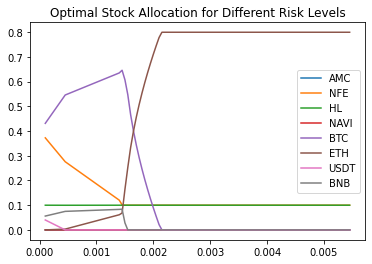

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'AMC', 'NFE', 'HL', 'NAVI', 'BTC','ETH','USDT','BNB']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward)

[0.0001, 0.00045000000000000004, 0.0014000000000000002, 0.0014500000000000003, 0.0015000000000000002, 0.0015500000000000004, 0.0016000000000000003, 0.0016500000000000004, 0.0017000000000000003, 0.0017500000000000003, 0.0018000000000000004, 0.0018500000000000003, 0.0019000000000000004, 0.0019500000000000003, 0.0020000000000000005, 0.00205, 0.0021000000000000003, 0.00215, 0.0022, 0.0022500000000000003, 0.0023000000000000004, 0.00235, 0.0024000000000000002, 0.0024500000000000004, 0.0025, 0.00255, 0.0026000000000000003, 0.0026500000000000004, 0.0027, 0.0027500000000000003, 0.0028000000000000004, 0.0028500000000000005, 0.0029000000000000002, 0.0029500000000000004, 0.0030000000000000005, 0.00305, 0.0031000000000000003, 0.0031500000000000005, 0.0032000000000000006, 0.0032500000000000003, 0.0033000000000000004, 0.0033500000000000005, 0.0034000000000000002, 0.0034500000000000004, 0.0035000000000000005, 0.0035500000000000006, 0.0036000000000000003, 0.0036500000000000005, 0.0037000000000000006, 0

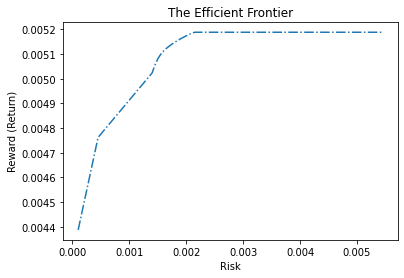

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

In [ ]:
param_analysis.loc[0.0020:0.002005,:]

,AMC,NFE,HL,NAVI,BTC,ETH,USDT,BNB
0.002,0.000003,0.1,0.099996,0.000007,0.088579,0.711359,0.000001,0.000056
